In [4]:
import h5py, os, pystan
import numpy as np
from os.path import dirname
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [5]:
import os, pystan
import _pickle as pickle
from pandas import DataFrame

def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel

In [6]:
PATH_NAME = '/Users/kierstenmarr/Desktop/EA'

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'EA'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [8]:
from numba import njit

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

In [25]:
class EA(object):
    
    def __init__(self, b1, b2, eta1, eta2, w, p):
        
        ## Define parameters.
        self.b1 = b1
        self.b2 = b2
        self.eta1 = eta1
        self.eta2 = eta2
        self.w = w
        self.p = p
        
        ## Initialize Q-values.
        self.Qs1 = None
        self.Qs2 = None
        
    def train(self, drifts, reset=False):
        
        ## Error-catching: rewards.
        ##drifts = np.array(drifts)
        
        ## Initialize Q-values.
        if self.Qs1 is None or reset:
            self.Qs1 = 0.5 * np.ones(2)
        
        if self.Qs2 is None or reset:
            self.Qs2 = 0.5 * np.ones((2,2))
            
        ## Preallocate space.
        n_trials = drifts.shape[0]
        Y = np.zeros((n_trials, 2), dtype=int)
        t = np.zeros(n_trials, dtype=int)
        r = np.zeros(n_trials, dtype=int)
        X = np.zeros(n_trials, dtype=int)
            
        for i in range(n_trials):

            theta1 = inv_logit( self.b1 * (self.Qs1[1] - self.Qs1[0]))
            
            ## Stage 1: Simulate choice.
            Y[i,0] = np.random.binomial(1,theta1)
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S = np.where(t[i], Y[i,0], 1-Y[i,0]) + 1
            X[i] = S-1
                        
            ## Stage 2: Compute choice likelihood.
            theta2 = inv_logit( self.b2 * (self.Qs2[X[i],1] - self.Qs2[X[i],0]) )
            
            ## Stage 2: Simulate choice.
            Y[i,1] = np.random.binomial(1,theta2)
            
            ## Stage 2: Observe outcome.
            #r[i] = R[i,S-1,Y[i,1]]
            r[i] = np.random.binomial(1, drifts[i, S-1, Y[i,1]])
            
            ## Update stage 2 Q-values
            self.Qs2[X[i], Y[i,1]] += self.eta2 * (r[i] - self.Qs2[X[i], Y[i,1]])
            # where's eta1 in all this?
            
            if (Y[i,0] == t[i]):
                ## common transition
                cr = 0.7
            else:
                ## rare transition
                cr = 0.3
            
            ## Update Stage 1 Q-values
            # Chosen action
            deltaC = r[i] - self.Qs1[Y[i,1]]
            self.Qs1[Y[i,1]] += self.eta1 * (self.w * cr * deltaC + (1 - self.w) * deltaC)
            
            # Unchosen action
            deltaU = r[i] - self.Qs1[1 - Y[i,1]]
            self.Qs1[1-Y[i,1]] += self.eta1 * self.w * (1-cr) * deltaU
            
        return Y, t, r, X

In [26]:
from tqdm import tqdm

100%|██████████| 201/201 [00:01<00:00, 104.36it/s]


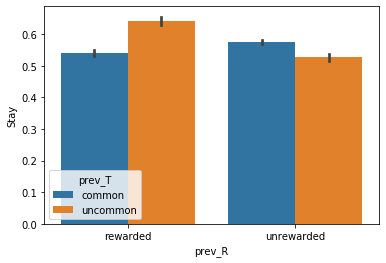

In [27]:
np.random.seed(47404)

## Define reward parameters.
drifts = read_csv('drifts.txt', header=None).values.reshape(-1,2,2)
T = drifts.shape[0]

data = []
for _ in tqdm(range(T)):
    
    ## Simulate outcomes.
    R = np.random.binomial(1, [[0.5,0.5],[0.5,0.5]], (200,2,2))
    
    ## Initialize agent.
    agent = EA(b1 = 5, b2 = 5, eta1 = 0.5, eta2 = 0.5, w = 0.5, p = 0.2)

    ## Train agent.
    Y, t, r, X = agent.train(drifts)
    
    ## Define variables.
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = Y[:-1,0] == Y[1:,0]

    ## Blah.
    df = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

In [42]:
R = r.astype(int)
R

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1])

In [43]:
X

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1])

In [45]:
# NOTE: haven't run whole block yet!
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=200, Y=Y, O=t, reward=R, X=X)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_421e6b579a1e24495504da1b54e3ca1d NOW.


In [46]:
StanModel.optimizing(data=dd)

RuntimeError: Initialization failed.

In [ ]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [ ]:
print(StanFit)